In [1]:
%run "08222019_functions.ipynb"

In [2]:
gcs_bucket_fs = gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token='anon', access='read_only')

In [3]:
hap_path = 'ag1000g-release/phase2.AR1/haplotypes/main/zarr/ag1000g.phase2.ar1.haplotypes'
store = gcs_bucket_fs.get_mapper(root=hap_path)

In [4]:
calldata_hap_phase2= zarr.Group(store, read_only=True)

In [15]:
accessibility_path = os.path.join("ag1000g-release/phase2.AR1/accessibility/accessibility.zarr")
gcsacmap = gcs_bucket_fs.get_mapper(root=accessibility_path)
accessibility= zarr.Group(gcsacmap, read_only=True)

In [8]:
###### loading phase2 metadata ######
metadata = pd.read_csv("samples.meta.csv", sep=",")
metadata.head()

,ox_code,src_code,population,country,location,site,contributor,contact,year,m_s,sex,n_sequences,mean_coverage,ebi_sample_acc,latitude,longitude,species
0,AA0040-C,Twifo_Praso__E2,GHcol,Ghana,Twifo Praso,Twifo Praso,David Weetman,David Weetman,2012,M,F,95033368,30.99,ERS311878,5.60858,-1.54926,acol
1,AA0041-C,Twifo_Praso__H3,GHcol,Ghana,Twifo Praso,Twifo Praso,David Weetman,David Weetman,2012,M,F,95843804,31.70,ERS311886,5.60858,-1.54926,acol
2,AA0042-C,Takoradi_C7,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,107420666,35.65,ERS311894,4.91217,-1.77397,acol
3,AA0043-C,Takoradi_H8,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,95993752,29.46,ERS311902,4.91217,-1.77397,acol
4,AA0044-C,Takoradi_D10,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,103044262,33.67,ERS311910,4.91217,-1.77397,acol


In [9]:
metadata.species.unique()

array(['acol', 'agam', 'na'], dtype=object)

In [10]:
pop_selection = metadata.species.isin({'acol', 'agam'}).values
pop_subset = metadata[pop_selection]

In [11]:
grp = pop_subset.groupby("species")
grp_indices = grp.indices
grp_indices

{'acol': array([  0,   1,   2,   3,   4,   6,   8,   9,  10,  11,  12,  13,  16,
         17,  18,  19,  20,  22,  23,  24,  25,  26,  27,  31,  32,  33,
         34,  35,  37,  38,  39,  40,  41,  42,  43,  44,  45,  47,  48,
         49,  50,  51,  52,  53,  55,  56,  57,  58,  59,  61,  62,  63,
         64,  65,  66,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  84,  85,  86,  87,  88,  89,  90,  94,  95,  96,
        106, 107, 108, 109, 110, 141, 142, 143, 144, 145, 146, 147, 148,
        149, 150, 151, 152, 153, 154, 162, 167, 168, 170, 171, 172, 175,
        176, 177, 178, 179, 180, 181, 183, 187, 190, 193, 195, 196, 198,
        199, 200, 201, 202, 208, 209, 212, 213, 216, 217, 225, 228, 231,
        676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688,
        689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701,
        702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714,
        715, 716, 717, 718, 719, 720, 721, 

In [ ]:
genotypes_phase2_call = calldata_hap_phase2['3L']["calldata/GT"]
genotypes_phase2 = allel.GenotypeChunkedArray(genotypes_phase2_call)
geno_p2_subset = genotypes_phase2.subset(sel1=pop_selection)

In [ ]:
geno_p2_subset

In [12]:
ac_subpops = geno_p2_subset.count_alleles_subpops(grp_indices)

In [13]:
ac_subpops

<AlleleCountsChunkedTable shape=(7897666,) dtype=[('acol', '<i4', (2,)), ('agam', '<i4', (2,))]
   nbytes=120.5M cbytes=24.5M cratio=4.9
   values=allel.chunked.storage_zarr.ZarrTable>

In [14]:
pos = calldata_hap_phase2['3L']['variants']['POS'][:]    
pos.shape

(7897666,)

In [15]:
pos = allel.SortedIndex(pos, copy=False)
pos

0,1,2,3,4,...,7897661,7897662,7897663,7897664,7897665
9790,9791,9798,9812,9815,...,41956530,41956532,41956537,41956541,41956551


In [16]:
pos.max()

41956551

In [17]:
is_accessible = accessibility['3L']['is_accessible'][:]

In [19]:
dxy, windows, n_bases, counts = allel.windowed_divergence(pos, ac_subpops['acol'], ac_subpops['agam'], 
                                                                    size=50000, 
                                                                    start=1, 
                                                                    stop=pos.max(),
                                                                    is_accessible=is_accessible
                                                             )

In [20]:
palette = sns.color_palette()

(0, 0.018)

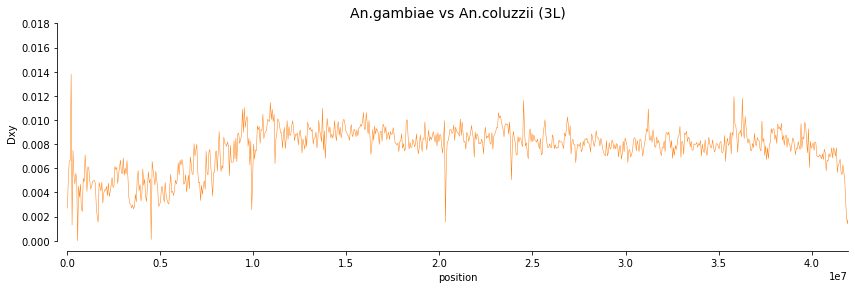

In [21]:
min_n_bases=1
x = np.mean(windows[n_bases >= min_n_bases], axis=1)
y = dxy[n_bases >= min_n_bases]
fig, ax = plt.subplots(figsize=(14, 4))
sns.despine(ax=ax, offset=10)
ax.plot(x, y, lw=.5,  color=palette[1])
ax.set_xlim(0, pos.max())
ax.set_title('%s vs %s (%s)' % ('An.gambiae', 'An.coluzzii', '3L'), fontsize=14)
ax.set_ylabel('Dxy')
ax.set_xlabel('position')
ax.set_ylim(0,0.018)

-------------------------------

## Pi between Aggam and Agcol

In [45]:
palette = sns.color_palette()
palette

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [26]:
pi_gam, windows_gam, n_bases_gam, counts_gam = allel.windowed_diversity(pos, ac_subpops['agam'], size=50000, start=1, stop=pos.max(), is_accessible=is_accessible)

In [27]:
pi_col, windows_col, n_bases_col, counts_col = allel.windowed_diversity(pos, ac_subpops['acol'], size=50000, start=1, stop=pos.max(), is_accessible=is_accessible)

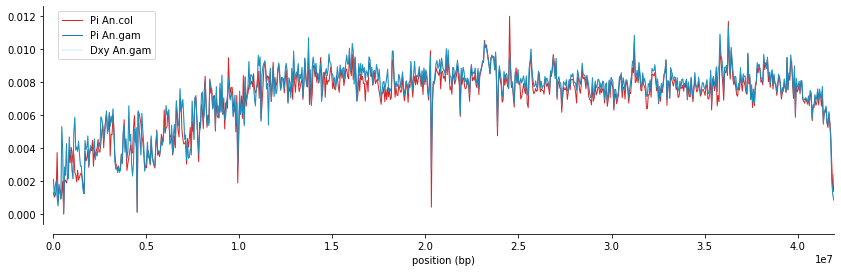

In [60]:
fig, ax = plt.subplots(figsize=(14, 4))

x1 = np.mean(windows_col[n_bases >= min_n_bases], axis=1)
y1 = pi_col[n_bases >= min_n_bases]
plt.plot(x1, y1, lw=1, label = "Pi An.col", color=palette[3]) 


x2 = np.mean(windows_gam[n_bases >= min_n_bases], axis=1)
y2 = pi_gam[n_bases >= min_n_bases]
plt.plot(x2, y2, lw=1, label = "Pi An.gam", color=palette[0]) 

x3 = np.mean(windows[n_bases >= min_n_bases], axis=1)
y3 = dxy[n_bases >= min_n_bases]
plt.plot(x2, y2, lw=.25, label = "Dxy An.gam", color=palette[9]) 

sns.despine(ax=ax, offset=10)
ax.set_xlim(0, pos.max())
ax.set_xlabel('position (bp)')
#ax.set_ylim(0,0.018)
sns.despine(ax=ax, offset=10)

# show a legend on the plot 
plt.legend() 

# function to show the plot 
plt.show()

-----------------------------------------

## Perform Dxy and pi all over the chromosomes

In [5]:
chromosomes = ['X', '3L', '3R', '2R', '2L']

In [6]:
def dxy_plot(pop1, pop2):
    
    for chrom in chromosomes:
            
            is_accessible = accessibility[chrom]['is_accessible'][:]

            ###### loading phase2 metadata ######
            metadata = pd.read_csv("../samples.meta.csv", sep=",")
            pop_selection = metadata.species.isin({pop1, pop2}).values
            pop_subset = metadata[pop_selection]


            ###### loading phase2 genome and subset ######
            genotypes_phase2_call = calldata_hap_phase2[chrom]["calldata/GT"]
            genotypes_phase2 = allel.GenotypeChunkedArray(genotypes_phase2_call)
            geno_p2_subset = genotypes_phase2.subset(sel1=pop_selection)


            ###### perform allele count to my subpopulations ######
            grp = pop_subset.groupby("species")
            grp_indices = grp.indices
            ac_subpops = geno_p2_subset.count_alleles_subpops(grp_indices)


            # run D test
            dxy, windows, n_bases, counts = allel.windowed_divergence(pos, ac_subpops[pop1], ac_subpops[pop2], 
                                                                    size=50000, 
                                                                    start=1, 
                                                                    stop=pos.max(),
                                                                    is_accessible=is_accessible
                                                             )    
            pi_gam, windows_gam, n_bases_gam, counts_gam = allel.windowed_diversity(pos, ac_subpops[pop1], size=50000, start=1, stop=pos.max(), is_accessible=is_accessible)
            pi_col, windows_col, n_bases_col, counts_col = allel.windowed_diversity(pos, ac_subpops[pop2], size=50000, start=1, stop=pos.max(), is_accessible=is_accessible)
            fig, ax = plt.subplots(figsize=(14, 4))

            x1 = np.mean(windows_col[n_bases >= min_n_bases], axis=1)
            y1 = pi_col[n_bases >= min_n_bases]
            plt.plot(x1, y1, lw=1, label = "Pi An.col", color=palette[3]) 


            x2 = np.mean(windows_gam[n_bases >= min_n_bases], axis=1)
            y2 = pi_gam[n_bases >= min_n_bases]
            plt.plot(x2, y2, lw=1, label = "Pi An.gam", color=palette[0]) 

            x3 = np.mean(windows[n_bases >= min_n_bases], axis=1)
            y3 = dxy[n_bases >= min_n_bases]
            plt.plot(x2, y2, lw=.25, label = "Dxy An.gam", color=palette[9]) 

            sns.despine(ax=ax, offset=10)
            ax.set_xlim(0, pos.max())
            ax.set_xlabel('position (bp)')
            #ax.set_ylim(0,0.018)
            sns.despine(ax=ax, offset=10)

            # show a legend on the plot 
            plt.legend() 

            # function to show the plot 
            plt.show()

In [7]:
dxy_plot('agam', 'acol')

IndexError: index 1099 is out of bounds for size 1099